# Evaluating the Model

### Install Requirements

In [57]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn
!pip install openpyxl

### Import Required Libraries

In [58]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import fiftyone as fo
import cv2
import matplotlib.pyplot as plt
import PIL
import requests

from pathlib import Path
from PIL import Image, ImageOps, ImageDraw, ImageFont
from PIL.ExifTags import TAGS
from pyzbar.pyzbar import decode, ZBarSymbol
from torchvision import transforms
from torchvision.ops import box_convert
from IPython.display import display
import argparse
import copy
from io import BytesIO

from detectron2 import model_zoo
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

from segment_anything import build_sam, SamPredictor
from pycocotools.coco import COCO

# Set up the logger for detectron2
setup_logger()


<Logger detectron2 (DEBUG)>

In [59]:
TEXT_PROMPT = "leaf"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

### Load SAM Model

In [60]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

### Specify Model

There are several output folders from training multiple models.  

In [61]:
import json

# set this to today's date
today = "2024-03-15"

# modify output folder suffix if needed
suffix = "kfold_train"

# name of output folder
output_folder_name = today + "_" + suffix

data_path = '/home/jovyan/work/data/2024-03-14_leaves'
output_folder = f'/home/jovyan/work/mask_rcnn/{output_folder_name}'
coco_annotation_path = '/home/jovyan/work/data/2024-03-14_leaves_rotated.json'
with open(coco_annotation_path) as f:
    coco_data = json.load(f)

    coco_annotations = coco_data['annotations']
    coco_images_info = coco_data['images']
    coco_categories = coco_data['categories']

k=5

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [62]:
import numpy as np

def calculate_iou(gtmask, test_mask):
    intersection = np.logical_and(gtmask, test_mask)
    union = np.logical_or(gtmask, test_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return (iou_score)

# Usually there is a mask for the entire plant in addition to individual leaves. 
# This function attempts to remove the full plant mask by caclculating the iou of each mask and the union of all masks.
def check_full_plant(masks):
    # Initialize the combined mask
    mask_all = np.zeros(masks[0].shape, dtype=np.float32)

    # Combine all masks into one
    for mask in masks:
        mask_all += mask.astype(np.float32)

    iou_withall = []
    # Calculate IoU for each mask with the combined mask
    for mask in masks:
        iou_withall.append(calculate_iou(mask, mask_all))

    idx_notall = np.array(iou_withall) < 0.9
    return idx_notall

def annotate_masks_in_image(masks, image, include, random_color=True):
    # Convert image to RGBA
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")

    
    # Iterate through each mask
    for i in range(masks.shape[0]):
        if (include[i]):
            mask = masks[i]
            if random_color:
                color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
            else:
                color = np.array([30/255, 144/255, 255/255, 0.6])

            h, w = mask.shape[-2:]
            mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

            mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

            # Composite the mask with the image
            annotated_frame_pil = Image.alpha_composite(annotated_frame_pil, mask_image_pil)
    
    return np.array(annotated_frame_pil)

# Returns relative bbox for FiftyOne and cropped mask
def get_bbox_for_plant(file_name):
    
    image_id = next(img['id'] for img in coco_data['images'] if img['file_name'] == file_name)

    # Get annotations for the image ID with label 'leaf'
    leaf_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id and coco_data['categories'][ann['category_id']]['name'] == 'leaf']

    # Calculate the bounding box that encompasses all leaf annotations
    if leaf_annotations:
        x_min = min(ann['bbox'][0] for ann in leaf_annotations)
        y_min = min(ann['bbox'][1] for ann in leaf_annotations)
        x_max = max(ann['bbox'][0] + ann['bbox'][2] for ann in leaf_annotations)
        y_max = max(ann['bbox'][1] + ann['bbox'][3] for ann in leaf_annotations)
        plant_bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
    else:
        plant_bbox = None

    return plant_bbox

def convert_bbox_to_full_image(bbox_cropped, bbox_full_image):
    x_min_cropped, y_min_cropped, width_cropped, height_cropped = bbox_cropped
    x_min_full, y_min_full, width_full, height_full = bbox_full_image

    x_min = x_min_full + x_min_cropped
    y_min = y_min_full + y_min_cropped
    x_max = x_min + width_cropped
    y_max = y_min + height_cropped

    return x_min, y_min, x_max, y_max

def adjust_mask(mask_cropped, bbox_cropped, full_image_shape):

    x_min_cropped, y_min_cropped, width_cropped, height_cropped = bbox_cropped
    full_image_height, full_image_width = full_image_shape[:2]

    if len(mask_cropped.shape) == 3 and mask_cropped.shape[0] == 1:
        mask_cropped = mask_cropped[0]

    # Create an empty mask for the full image
    mask_full = np.zeros((full_image_height, full_image_width), dtype=bool)

    # Determine the location in the full image where the cropped mask should be placed
    x_min_full = int(x_min_cropped)
    y_min_full = int(y_min_cropped)

    # Place the cropped mask in the corresponding location in the full image mask
    mask_full[y_min_full:y_min_full+mask_cropped.shape[0], x_min_full:x_min_full+mask_cropped.shape[1]] = mask_cropped

    return mask_full



In [63]:
import matplotlib.patches as patches

# x_min: The x-coordinate of the top-left corner of the bounding box.
# y_min: The y-coordinate of the top-left corner of the bounding box.
# width: The width of the bounding box.
# height: The height of the bounding box.

def visualize_bbox(image_path, bbox):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

In [64]:
# Returns relative bbox for FiftyOne and cropped mask
def relative_mask_bbox(mask, file_name, image):
    
    plant_bbox = get_bbox_for_plant(file_name)
    # Assume we have the bbox of the full image
    
    if not plant_bbox:
        plant_bbox = [0, 0, image.shape[1], image.shape[0]]
    
    bbox_full_image = [0, 0, image.shape[1], image.shape[0]]  # Full image bounding box

    # Convert bbox to full image coordinates
    bbox_full = convert_bbox_to_full_image(plant_bbox, bbox_full_image)
    mask_full = adjust_mask(mask, plant_bbox, image.shape)
    

    # Find the coordinates of the nonzero elements in the mask
    nonzero_rows, nonzero_cols = np.nonzero(mask_full)

    # Calculate the bounding box of the leaf
    x_min = np.min(nonzero_cols)
    x_max = np.max(nonzero_cols)
    y_min = np.min(nonzero_rows)
    y_max = np.max(nonzero_rows)

    # Create an array representing the bounding box [x_min, y_min, width, height]
    cropped_mask = mask_full[y_min:y_max, x_min:x_max]\

    return x_min, y_min, x_max, y_max, cropped_mask

        

In [65]:
def is_bbox_large(bbox, threshold=0.9):
    """
    Check if bbox covers a large portion of the image.

    Parameters:
    - bbox: List representing the bounding box [x, y, width, height].
    - threshold: Threshold percentage for considering a bbox as covering a large portion of the image.

    Returns:
    - True if bbox covers a large portion of the image, False otherwise.
    """
    _, _, width, height = bbox
    bbox_area = width * height
    image_area = 1.0  # Assuming image area is 1 (normalized coordinates)
    return bbox_area >= threshold * image_area

def filter_large_bboxes(boxes, threshold=0.9):
    """
    Filter out bounding boxes that cover a large portion of the image.

    Parameters:
    - boxes: Tensor of bounding boxes in the format (left, top, width, height).
    - image_size: Tuple representing the size of the image (width, height).
    - threshold: Threshold percentage for considering a bbox as covering a large portion of the image.

    Returns:
    - Tensor of bounding boxes that do not cover a large portion of the image.
    """
    filtered_boxes = []
    for bbox in boxes:
        if not is_bbox_large(bbox, threshold):
            filtered_boxes.append(bbox)
    if len(filtered_boxes) > 0:
        return torch.stack(filtered_boxes)
    else:
        # Return an empty tensor with the same shape as the input boxes
        return torch.empty_like(boxes)

In [66]:
def check_color(masks, hsv):
    colors = np.zeros((0,3))

    for i in range(len(masks)):
        color = hsv[masks[i]['segmentation']].mean(axis=(0))
        colors = np.append(colors, color[None, :], axis=0)
    
    # Define a range for hue, saturation, and value (brightness)
    hue_lower_bound = 70
    hue_upper_bound = 100  # or 100 if grow lights are on
    saturation_lower_bound = 30
    value_lower_bound = 40  # Example value, adjust as needed
    value_upper_bound = 255  # Example value, adjust as needed

    idx_green = (colors[:,0] < hue_upper_bound) & (colors[:,0] > hue_lower_bound) & \
                (colors[:,1] > saturation_lower_bound) & \
                (colors[:,2] > value_lower_bound) & (colors[:,2] < value_upper_bound)

    if idx_green.sum() == 0:
        # If no greens found, adjust hue for grow lights
        hue_upper_bound = 100
        idx_green = (colors[:,0] < hue_upper_bound) & (colors[:,0] > hue_lower_bound) & \
                    (colors[:,1] > saturation_lower_bound) & \
                    (colors[:,2] > value_lower_bound) & (colors[:,2] < value_upper_bound)
    
    return idx_green

def generate_unique_color(existing_colors):
    """
    Generate a unique random color that's not in existing_colors.
    """
    while True:
        new_color = [random.randint(0, 255) for _ in range(3)]
        if not any((np.array(new_color) == x).all() for x in existing_colors):
            return new_color
    
def apply_mask_to_image(image, mask):
    """
    Apply a single mask to the image, creating a colored overlay
    """
    # Create an overlay that is a copy of the original image
    overlay = image.copy()
    
    # Generate a random color for the mask
    color = np.array([random.randint(0, 255) for _ in range(3)], dtype=np.uint8)
    
    # Resize mask to match image dimensions
    resized_mask = cv2.resize(mask.astype(float), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    resized_mask = resized_mask > 0.5  # Ensure binary mask
    
    # Apply the color to the overlay where the mask is true
    overlay[resized_mask] = overlay[resized_mask] * 0.5 + color * 0.5
    
    return overlay


In [67]:
def issubset(mask1, mask2):
    # is mask2 subpart of mask1
    intersection = np.logical_and(mask1, mask2)
    return(np.sum(intersection)/mask2.sum()>0.8)

def intersect(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return(np.sum(intersection)/mask2.sum())

def istoobig(masks):
    idx_toobig = []
    
    mask_all = np.zeros(masks[0]['segmentation'].shape[:2])

    for mask in masks:
        mask_all +=mask['segmentation']*1 

    for idx, mask1 in enumerate((masks)):
        # print('\n')
        # print(idx)
        if idx in idx_toobig:
            continue
        for idx2, mask2 in enumerate((masks)):
            # print(idx2)
            if idx==idx2:
                continue
            if idx2 in idx_toobig:
                continue
            # print('intersection: ', intersect(mask1['segmentation'], mask2['segmentation']))
            if issubset(mask1['segmentation'], mask2['segmentation']):
                # print('issubset')
                # check if actually got both big and small copy delete if do
                if mask_all[masks[idx2]['segmentation']].mean() > 1:
                
                    idx_toobig.append(idx2)
            else:
                # print('check iou')
                iou_score = calculate_iou(mask1['segmentation'], mask2['segmentation'])
                # print('iou: ', iou_score)
                if iou_score > 0.4:
                    # If there's a significant overlap, and mask1 is bigger than mask2
                    if np.sum(mask1['segmentation']) <= np.sum(mask2['segmentation']):
                        idx_toobig.append(idx2)
                        break  # No need to check other masks for this idx
    
    idx_toobig.sort(reverse=True)        
    return(idx_toobig)


def remove_toobig(masks, idx_toobig):
    masks_ntb = masks.copy()

    idx_del = []
    for idxbig in idx_toobig:
        # print("removing:", idxbig)
        
#         maskbig = masks_ntb[idxbig]['segmentation'].copy()
#         submasks = np.zeros(maskbig.shape)

#         for idx in range(len(masks_ntb)):
#             if idx==idxbig:
#                 continue
#             if issubset(masks_ntb[idxbig]['segmentation'], masks_ntb[idx]['segmentation']):
#                 submasks +=masks_ntb[idx]['segmentation']

#         if np.logical_and(maskbig, submasks>0).sum()/maskbig.sum()>0.9:
#             # can safely remove maskbig
#             idx_del.append(idxbig)
        del(masks_ntb[idxbig])
    # print('final:', masks_ntb)
            
    return(masks_ntb)


def getbiggestcontour(contours):
    nopoints = [len(cnt) for cnt in contours]
    return(np.argmax(nopoints))

def checkshape(masks):
    cratio = []

    for i in range(len(masks)):
        test_mask = masks[i]['segmentation']
        
        if not test_mask.max():
            cratio.append(0)
        else:

            contours,hierarchy = cv2.findContours((test_mask*255).astype('uint8'), 1, 2)

            # multiple objects possibly detected. Find contour with most points on it and just use that as object
            cnt = contours[getbiggestcontour(contours)]
            M = cv2.moments(cnt)

            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt,True)

            (x,y),radius = cv2.minEnclosingCircle(cnt)

            carea = np.pi*radius**2

            cratio.append(area/carea)
    idx_shape = np.array(cratio)>0.1
    return(idx_shape)

def check_full_plant_mask(masks):
    mask_all = np.zeros(masks[0]['segmentation'].shape[:2])

    for mask in masks:
        mask_all +=mask['segmentation']*1
        
    iou_withall = []
    for mask in masks:
        iou_withall.append(calculate_iou(mask['segmentation'], mask_all>0))
        
    idx_notall = np.array(iou_withall)<0.9
    return idx_notall

In [70]:
import numpy as np
from PIL import Image, ImageOps
import fiftyone as fo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage import color
import random


sam_image_dir = '/home/jovyan/work/data/leaves_cropped'
sam_output_folder = '/home/jovyan/work/data/leaf_only_sam/npz2'

# Assuming leaf_predictor is defined elsewhere and dataset is an iterable of samples
datasets = {}

# 
for fold in range(0, 5):
    
    base_path = f"{output_folder}/fold_{fold}/"

    leaf_cfg = get_cfg()
    leaf_cfg.MODEL.DEVICE='cpu'
    leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
    leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

    leaf_predictor = DefaultPredictor(leaf_cfg)
    
    print(f'Loading fold {fold} into fiftyone dataset...')
    
    datasets[f'fold_{fold}'] = fo.Dataset.from_dir(
        data_path=f"{data_path}",
        labels_path=f"{output_folder}/test_{fold}.json",
        dataset_type=fo.types.COCODetectionDataset, 
        name=f"{today}_fold_{fold}",
        label_types="segmentations",
        overwrite=True
    )
    
    print(f'Performing inference for fold {fold}...')

    with fo.ProgressBar() as pb:
        for sample in pb(datasets[f'fold_{fold}']):
            
            image = Image.open(sample.filepath)
            file_name = os.path.basename(sample.filepath)
            print(file_name)
            image = ImageOps.exif_transpose(image)  # Ensure correct orientation
            image_arr = np.array(image)
            h, w, _ = image_arr.shape
            name, ext = os.path.splitext(file_name)

            
            ## --------------- MASK-RCNN ----------------
            
            outputs = leaf_predictor(image_arr)

            # Initialize counters for each class
            red_square_pixels, leaf_pixels, qr_pixels = 0, 0, 0
            mask_rcnn_detections = []

            for i, (mask, box, label, score) in enumerate(zip(outputs["instances"].pred_masks.numpy(),
                                                              outputs["instances"].pred_boxes.tensor.numpy(),
                                                              outputs["instances"].pred_classes.numpy(),
                                                              outputs["instances"].scores.numpy())):
                x1, y1, x2, y2 = box
                rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]  # Relative bounding box
                
   
                bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
                mask_pixel_count = np.count_nonzero(bbox_mask)

                class_label = ['leaf', 'qr', 'red-square'][label]

                # Update pixel counts based on class
                if class_label == 'leaf':
                    leaf_pixels += mask_pixel_count
                elif class_label == 'red-square':
                    red_square_pixels += mask_pixel_count  # Assuming you want to sum red square pixels
                elif class_label == 'qr':
                    qr_pixels += mask_pixel_count
                    

                mask_rcnn_detections.append(fo.Detection(
                    label=class_label,
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                ))

            # print(f'image: {sample.filepath}, red_square_pixels: {red_square_pixels}, leaf_pixels: {leaf_pixels}, qr_pixels: {qr_pixels}')

            # Calculate leaf area
            leaf_area = None
            if red_square_pixels:
                # Red square is 2cm x 2cm, or 4 cm2
                leaf_area = (4 * leaf_pixels) / red_square_pixels
            elif qr_pixels:
                 # QR is 1.2cm x 1.2cm, or 1.44 cm2
                leaf_area = (1.44 * leaf_pixels) / qr_pixels

                
            
            # --------------------- Leaf Only SAM --------------------
            
            npz_file_path = f"{sam_output_folder}/{name}_croppedleafonly_allmasks.npz"
            cropped_image_path = f"{sam_image_dir}/{name}_cropped{ext}"
            
            try:
                mask_data = np.load(npz_file_path, allow_pickle=True)
            except:
                sample["predictions"] = fo.Detections(detections=mask_rcnn_detections)
                sample["leaf_only_sam_predictions"] = fo.Detections(detections=[])
                sample["red_square_pixels"] = red_square_pixels
                sample["qr_pixels"] = qr_pixels
                sample["height"] = h
                sample["width"] = w
                sample["area"] = leaf_area
                sample.tags.append(os.path.basename(sample.filepath))
                sample.save()
                continue
            
            cropped_image = mpimg.imread(cropped_image_path)
            
            overlay = np.zeros_like(cropped_image)
            used_colors = []
            all_masks = mask_data['arr_0']
            hsv = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
            idx_green = check_color(all_masks, hsv)
            
            
            # print(idx_green)
            masks_g = []
            for idx, use in enumerate(idx_green):
                if use:
                    masks_g.append(all_masks[idx])
                    
                    
            if len(masks_g) > 2:

                # check to see if full plant detected and remove
                idx_notall = check_full_plant_mask(masks_g)

                masks_na = []

                for idx, use in enumerate(idx_notall):
                    if use:
                        masks_na.append(masks_g[idx])

            else:
                masks_na = masks_g

            idx_shape = checkshape(masks_na)

            masks_s = []
            for idx, use in enumerate(idx_shape):
                if use:
                    masks_s.append(masks_na[idx])
            
            if len(masks_s) > 0:
                idx_toobig = istoobig(masks_s)
                # print(idx_toobig)
                masks_ntb = remove_toobig(masks_s, idx_toobig)
            else:
                masks_ntb = []
            
            masked_image = cropped_image
            
            masks_not_too_small = []

            # Loop through each mask
            for i, mask in enumerate(masks_ntb):
                segmentation_info = mask
                segmentation_mask = segmentation_info['segmentation']
                non_zero_count = np.count_nonzero(segmentation_mask)
                if non_zero_count >= 400:
                    # Generate a unique color for this mask
                    unique_color = generate_unique_color(used_colors)
                    used_colors.append(unique_color)
                    masks_not_too_small.append(segmentation_mask)
                    masked_image = apply_mask_to_image(masked_image, segmentation_mask)
            
            output_image = Image.fromarray(masked_image)
            output_image.save(f"/home/jovyan/work/data/leaf_only_sam/results/{name}_final.png")
            
            leaf_only_sam_detections = []


            # Add Grounded SAM to FiftyOne dataset
            for mask_np in masks_not_too_small:
                
            

                # Get bbox of cropped plant within full image
                # Overlay mask_np into full image
                # get bbox in relation to full image
                # get mask cropped to bbox

                x1, y1, x2, y2, bbox_mask = relative_mask_bbox(mask_np, file_name, image_arr)
                # print(box_mask)
                # visualize_bbox(sample.filepath, [x1, y1, x2-x1, y2-y1])
                # print([
                #     min(x1, x2)  / image.width, 
                #     min(y1, y2) / image.height, 
                #     abs(x2 - x1) / image.width, 
                #     abs(y2 - y1) / image.height
                # ])

                leaf_only_sam_detections.append(fo.Detection(
                    label='leaf',
                    bounding_box=[
                        min(x1, x2)  / image.width, 
                        min(y1, y2) / image.height, 
                        abs(x2 - x1) / image.width, 
                        abs(y2 - y1) / image.height
                    ],
                    mask=bbox_mask
                ))
                        


            # Update sample with detections and calculated area
            sample["predictions"] = fo.Detections(detections=mask_rcnn_detections)
            sample["leaf_only_sam_predictions"] = fo.Detections(detections=leaf_only_sam_detections)
            sample["red_square_pixels"] = red_square_pixels
            sample["qr_pixels"] = qr_pixels
            sample["height"] = h
            sample["width"] = w
            sample["area"] = leaf_area
            sample.tags.append(os.path.basename(sample.filepath))
            sample.save()


[06/19 00:09:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-15_kfold_train/fold_0/model_final.pth ...
Loading fold 0 into fiftyone dataset...
 100% |███████████████████| 36/36 [10.9s elapsed, 0s remaining, 3.0 samples/s]      
Performing inference for fold 0...
IMG_5858.JPG                                                                
IMG_5869.JPG                                                                    
IMG_5871.JPG                                                                    
IMG_5879.JPG                                                                    
IMG_5908.JPG                                                                    
IMG_5918.JPG                                                                     
IMG_5924.JPG                                                                     
IMG_5951.JPG                                                                     
IMG_5957.JPG             

IMG_6055.JPG
IMG_6055
Precision:  1.0
Recall:  0.7
Num matches: 7


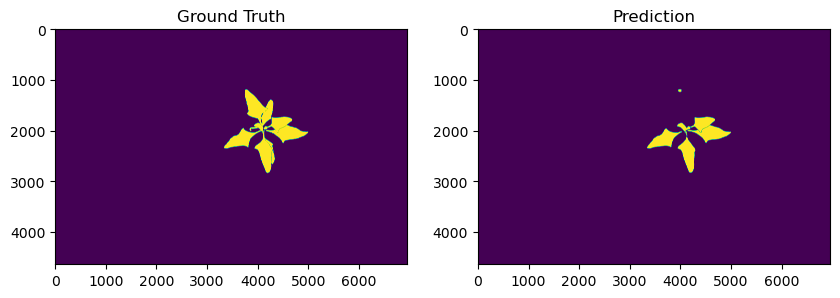

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def convert_to_pixels(bbox, height, width):
    x1, y1, w, h = bbox
    return [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]

def calculate_mask(detections, height, width):

    # rebuild full mask
    mask = np.zeros((height, width), dtype=bool)
    for d in detections:
        if d.label == 'leaf':
            bbox = d.bounding_box
            x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
            mask[round(y1):round(y2), round(x1):round(x2)] |= d.mask
    return mask

def calculate_iou_and_dice(gt_mask, pred_mask):
    # if np.count_nonzero(gt_mask) == 0 and np.count_nonzero(pred_mask) == 0:
    #     # Perfect agreement in the absence of objects
    #     return 1, 1
    
    intersect = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    # Normal IoU and Dice calculation when there are objects
    iou = intersect_pixels / union_pixels if union_pixels else None
    dice = (2 * intersect_pixels) / (np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask)) if np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask) else None
    
    return iou, dice

def visualize_masks(gt_mask, pred_mask):
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')
    axarr[0].imshow(gt_mask)
    axarr[1].imshow(pred_mask)
    plt.show()
    

def calculate_precision_recall(ground_truths, predictions, iou_threshold=0.5):
    matches = []
    matched_gt_indices = set()  # To track which ground_truths are matched

    # Matching detections between predictions and ground_truths
    for pred in predictions:
        best_iou = 0
        best_match_index = None
        for index, gt in enumerate(ground_truths):
            iou, dice = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])
            if iou > best_iou:
                best_iou = iou
                best_match_index = index
        if best_iou >= iou_threshold:
            matches.append((pred, ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(predictions) - true_positives
    false_negatives = len(ground_truths) - len(matched_gt_indices)  # Ground truths not matched

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches)

def calculate_pixel_level_precision_recall(gt_mask, pred_mask):
    TP = np.sum(np.logical_and(pred_mask == 1, gt_mask == 1))
    FP = np.sum(np.logical_and(pred_mask == 1, gt_mask == 0))
    FN = np.sum(np.logical_and(pred_mask == 0, gt_mask == 1))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return precision, recall


def calculate_precision_recall_count(ground_truths, predictions, iou_threshold=0.5):
    # Filter detections to include only those with the label 'leaf'
    filtered_ground_truths = [gt for gt in ground_truths if gt['label'] == 'leaf']
    filtered_predictions = [pred for pred in predictions if pred['label'] == 'leaf']

    matches = []
    matched_gt_indices = set()  # Tracks which ground_truths are matched

    # Matching detections between filtered predictions and filtered ground_truths
    for pred_index, pred in enumerate(filtered_predictions):
        best_iou = 0
        best_match_index = None
        for gt_index, gt in enumerate(filtered_ground_truths):
            if gt_index in matched_gt_indices:
                continue  # Skip already matched ground truths
            # print(gt)
            iou, _ = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])  # Dice can be ignored if not needed
            if iou > best_iou:
                best_iou = iou
                best_match_index = gt_index
        
        if best_iou >= iou_threshold:
            matches.append((pred, filtered_ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(filtered_predictions) - true_positives
    false_negatives = len(filtered_ground_truths) - len(matched_gt_indices)
    


    # Keep the original print statements
    # print('True positives: ', true_positives)
    # print('False positives: ', false_positives)
    # print('False negatives: ', false_negatives)

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches), true_positives, false_positives, false_negatives



dataset_1 = datasets['fold_0']
# print(dataset_1)
sample = dataset_1.last()
print(sample.filename)
height, width = sample.height, sample.width
ground_truth_detections = sample.ground_truth.detections
predictions = sample.leaf_only_sam_predictions.detections

ground_truth_mask = calculate_mask(ground_truth_detections, height, width)
prediction_mask = calculate_mask(predictions, height, width)
filename = sample.filepath.split('/')[-1].split('.')[0]
print(filename)
precision, recall, num_matches, tp, fp, fn = calculate_precision_recall_count(ground_truth_detections, predictions)
print('Precision: ', precision)
print('Recall: ', recall)
print('Num matches:', num_matches)


visualize_masks(ground_truth_mask, prediction_mask)
    

In [72]:
def count_leaves(detections):
    return sum(1 for d in detections if hasattr(d, 'label') and d.label == 'leaf')

In [73]:
import pandas as pd

# initialize dataframe from manual area file, and add column for ml_area
df = pd.read_excel('/home/jovyan/work/data/manual_area_count.xlsx')

columns_to_initialize = ['ml_area', 'leaf_only_sam_area', 'ml_leaf_count', 'ground_truth_pixels', 'prediction_pixels', 'iou', 'dice', 'count_precision', 'count_recall', 'num_matches', 'tp', 'fp', 'fn',  'mask_precision', 'mask_recall']

# Initialize columns to None and then convert to float
for column in columns_to_initialize:
    df[column] = None
    df[column] = df[column].astype(float)

df['fold'] = "fold"
    
missing_from_file = []

for fold_name, dataset in datasets.items():
    
    print('\n' + fold_name)
    print('---------------------------')
    
    fold_iou = []
    fold_dice = []

    for sample in dataset:

        filename = sample.filepath.split('/')[-1].split('.')[0]
        ground_truth_detections = sample.ground_truth.detections
        prediction_detections = sample.leaf_only_sam_predictions.detections
        
        ground_truth_mask = calculate_mask(ground_truth_detections, height, width)
        prediction_mask = calculate_mask(prediction_detections, height, width)
        leaf_pixels = np.count_nonzero(prediction_mask)
        
        # Calculate leaf area
        leaf_area = None
        if sample.red_square_pixels:
            # Red square is 2cm x 2cm, or 4 cm2
            leaf_area = (4 * leaf_pixels) / red_square_pixels
        elif sample.qr_pixels:
            # QR is 1.2cm x 1.2cm, or 1.44 cm2
            leaf_area = (1.44 * leaf_pixels) / qr_pixels

        if not df.loc[df['picture'].str.startswith(filename)].empty:
            df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2))
            df.loc[df['picture'].str.startswith(filename), 'leaf_only_sam_area'] = float(round(leaf_area, 2))
            df.loc[df['picture'].str.startswith(filename), 'ml_leaf_count'] = count_leaves(prediction_detections)
        else:
            missing_from_file.append(filename)
        
        height, width = sample.height, sample.width
        precision, recall, matches, tp, fp, fn = calculate_precision_recall_count(ground_truth_detections, prediction_detections)

        print(filename)

        iou, dice = calculate_iou_and_dice(ground_truth_mask, prediction_mask)
        pixel_precision, pixel_recall = calculate_pixel_level_precision_recall(ground_truth_mask, prediction_mask)
        # print(pixel_precision,  pixel_recall)
 
        
        # print(dice)
        row = df['picture'].str.startswith(filename)
        
        df.loc[row, 'ground_truth_pixels'] = np.count_nonzero(ground_truth_mask)
        df.loc[row, 'prediction_pixels'] = np.count_nonzero(prediction_mask)
        df.loc[row, 'iou'] = round(iou, 3) if iou is not None else None
        df.loc[row, 'dice'] = round(dice, 3) if dice is not None else None
        df.loc[row, 'count_precision'] = round(precision, 3)
        df.loc[row, 'count_recall'] = round(recall, 3)
        df.loc[row, 'num_matches'] = matches  
        df.loc[row, 'tp'] = tp  
        df.loc[row, 'fp'] = fp  
        df.loc[row, 'fn'] = fn
        df.loc[row, 'fold'] = fold_name
        df.loc[row, 'mask_precision'] = pixel_precision
        df.loc[row, 'mask_recall'] = pixel_recall
        
        fold_iou.append(iou)
        fold_dice.append(dice)

        # visualize_masks(ground_truth_mask, prediction_mask)
    
    fold_iou = np.array(fold_iou, dtype=float)
   

    print('Min IOU: ', np.nanmin(fold_iou))
    print('Max IOU: ', np.nanmax(fold_iou))
    print('Average IOU: ', np.nanmean(fold_iou))

    print('\n')
    fold_dice = np.array(fold_dice, dtype=float)
    print('Min Dice: ', np.nanmin(fold_dice))
    print('Max Dice: ', np.nanmax(fold_dice))
    print('Average Dice: ', np.nanmean(fold_dice))


df_area = df[df['ml_area'] >= 0.0]
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)

# Calculate means for specific columns
mean_values = {
    'ground_truth_pixels': None,
    'prediction_pixels': None,
    'iou': np.nanmean(df['iou']),
    'dice': np.nanmean(df['dice']),
    'count_precision': df['count_precision'].mean(),
    'count_recall': df['count_recall'].mean(),
    'mask_precision': df['mask_precision'].mean(),
    'mask_recall': df['mask_recall'].mean(),
    'num_matches': None,
}

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_values, index=['average'])

# Append the new DataFrame with averages to the original DataFrame
df = pd.concat([df, mean_df])


# Specify the path and name of the CSV file you want to create
csv_file_path = f'{output_folder}/{output_folder_name}.csv'

# Export the DataFrame to CSV
df.to_csv(csv_file_path, index=False)



fold_0
---------------------------
IMG_5858
IMG_5869
IMG_5871
IMG_5879
IMG_5908
IMG_5918
IMG_5924
IMG_5951
IMG_5957
IMG_5958
IMG_5959
IMG_5962
IMG_5970
IMG_5973
IMG_5976
IMG_5984
IMG_5985
IMG_5990
IMG_5993
IMG_5997
IMG_5998
IMG_6000
IMG_6001
IMG_6002
IMG_6008
IMG_6009
IMG_6010
IMG_6019
IMG_6035
IMG_6037
IMG_6039
IMG_6041
IMG_6043
IMG_6047
IMG_6050
IMG_6055
Min IOU:  0.0
Max IOU:  0.9403447398098667
Average IOU:  0.6094310035161885


Min Dice:  0.0
Max Dice:  0.9692553292380514
Average Dice:  0.6950304882457233

fold_1
---------------------------
IMG_5850
IMG_5856
IMG_5862
IMG_5873
IMG_5874
IMG_5875
IMG_5910
IMG_5913
IMG_5914
IMG_5919
IMG_5922
IMG_5925
IMG_5933
IMG_5935
IMG_5936
IMG_5937
IMG_5938
IMG_5939
IMG_5947
IMG_5953
IMG_5955
IMG_5968
IMG_5969
IMG_5971
IMG_5972
IMG_5978
IMG_5987
IMG_5995
IMG_6016
IMG_6024
IMG_6027
IMG_6028
IMG_6034
IMG_6040
IMG_6042
Min IOU:  0.0
Max IOU:  0.9433773465402276
Average IOU:  0.5742997989558355


Min Dice:  0.0
Max Dice:  0.9708637884656951
Average D

R2:  0.7885894076945299
p:  1.3121502389465112e-60


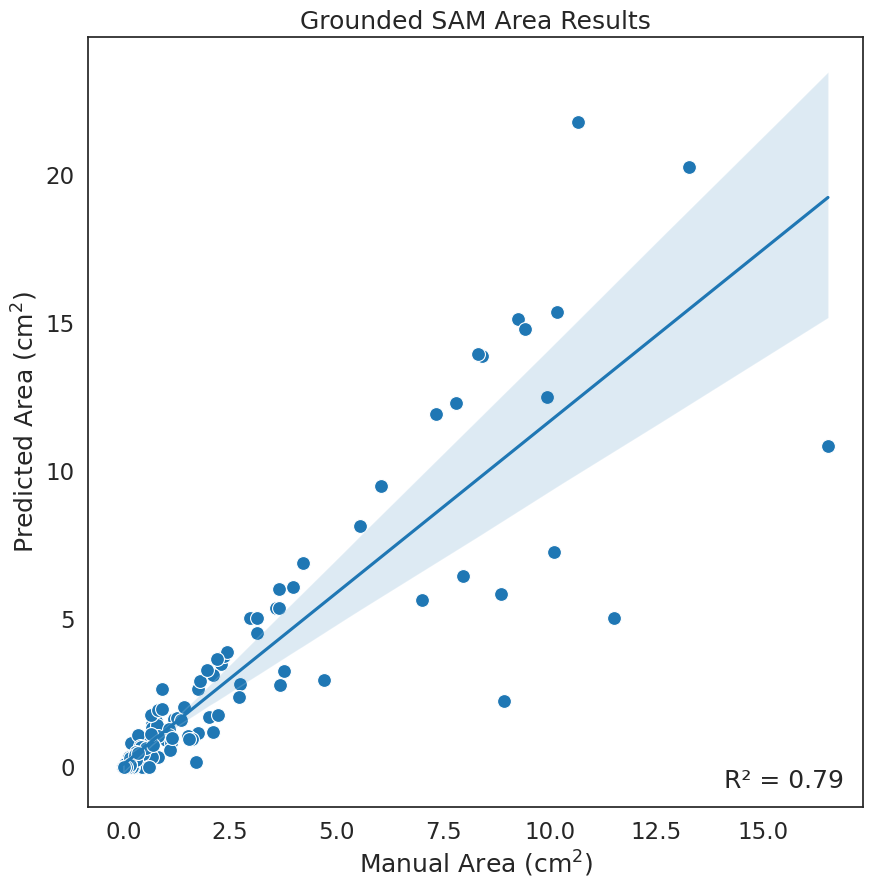

In [75]:

# plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
# plt.set(xlabel='Manual Area', ylabel='Predicted Area')
# plt.set(title="Leaf Area Results (cm$^{2}$)")
# plt.savefig("leaf_area.png", dpi=300)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

count_r, count_p = stats.pearsonr(df_area.area_cm2, df_area.leaf_only_sam_area)
count_r_squared = count_r**2
print('R2: ', count_r_squared)
print('p: ', count_p)

sns.set(style="white", palette=None, font_scale=1.5)

# Create scatter plot
sns.scatterplot(data=df_area, x='area_cm2', y='leaf_only_sam_area', s=100)

# Add regression line
sns.regplot(data=df_area, x='area_cm2', y='leaf_only_sam_area', scatter=False)

# Customize plot labels and title
plt.xlabel('Manual Area (cm$^{2}$)')
plt.ylabel('Predicted Area (cm$^{2}$)')
plt.title('Grounded SAM Area Results')

# # Annotate points
ax = plt.gca()
# for line in range(0, df_area.shape[0]):
#     ax.text(df_area.Leaves[line] + 0.01, df_area.ml_leaf_count[line], 
#             df_area.picture[line], horizontalalignment='left', 
#             size='medium', color='purple', weight='semibold')

# Annotate R-squared value
ax.text(0.82, 0.05, f'R² = {count_r_squared:.2f}', transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='left', 
        bbox=dict(facecolor='white', alpha=0.5))


# Save the plot
plt.savefig("leaf_area.png", dpi=300)

# Show the plot
plt.show()


R2:  0.9878236277623764
p:  7.085922612999256e-160


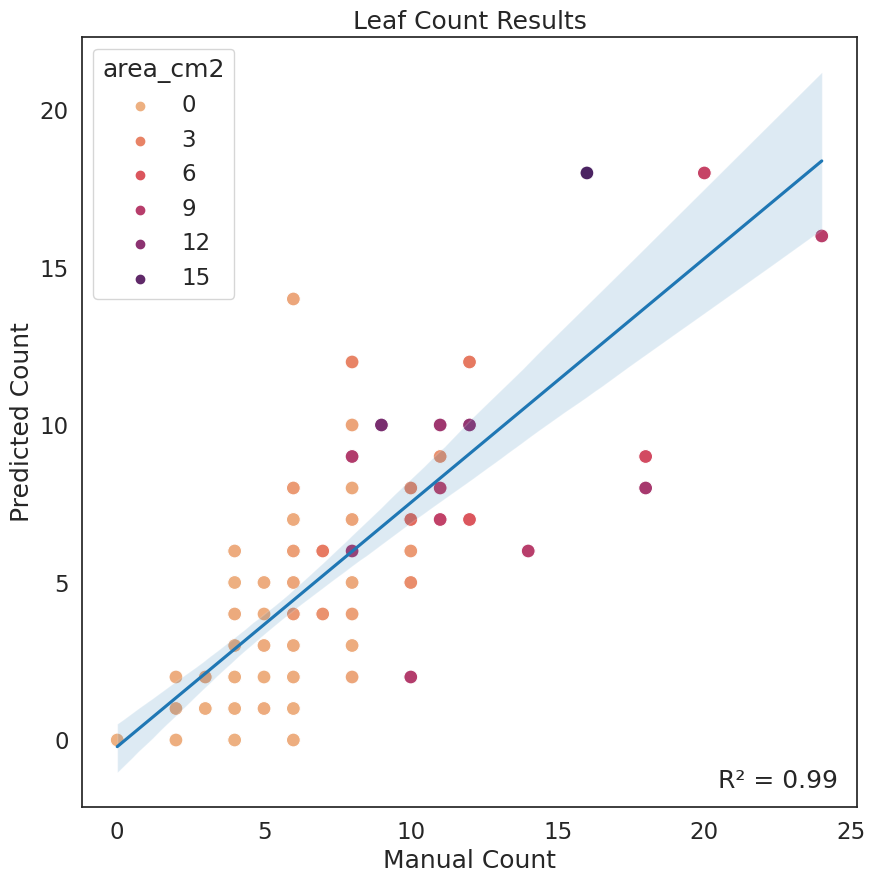

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df_area_count = df_area.dropna(subset=['Leaves', 'ml_leaf_count'])
count_r, count_p = stats.pearsonr(df_area_count.area_cm2, df_area_count.ml_area)

count_r_squared = count_r**2
print('R2: ', count_r_squared)
print('p: ', count_p)

sns.set(style="white", palette=None, font_scale=1.5)

# Create scatter plot
sns.scatterplot(data=df_area_count, x='Leaves', y='ml_leaf_count', s=100, hue='area_cm2', palette=sns.color_palette("flare", as_cmap=True))

# Add regression line
sns.regplot(data=df_area, x='Leaves', y='ml_leaf_count', scatter=False)

# Customize plot labels and title
plt.xlabel('Manual Count')
plt.ylabel('Predicted Count')
plt.title('Leaf Count Results')

# # Annotate points
ax = plt.gca()
# for line in range(0, df_area.shape[0]):
#     ax.text(df_area.Leaves[line] + 0.01, df_area.ml_leaf_count[line], 
#             df_area.picture[line], horizontalalignment='left', 
#             size='medium', color='purple', weight='semibold')

# Annotate R-squared value
ax.text(0.82, 0.05, f'R² = {count_r_squared:.2f}', transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='left', 
        bbox=dict(facecolor='white', alpha=0.5))


# Save the plot
plt.savefig("leaf_count.png", dpi=300)

# Show the plot
plt.show()

In [46]:
df_area.corr(numeric_only=True)

,area_cm2,Unnamed: 2,Leaves,ml_area,ml_leaf_count,ground_truth_pixels,prediction_pixels,iou,dice,count_precision,count_recall,num_matches,tp,fp,fn,mask_precision,mask_recall
area_cm2,1.000000,NaN,0.747964,0.993802,0.732871,0.959802,0.949654,0.320556,0.259220,0.138091,0.101896,0.732871,0.743293,0.109309,0.462299,0.225182,0.260910
Unnamed: 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Leaves,0.747964,NaN,1.000000,0.764713,0.839626,0.646200,0.638214,0.345216,0.299336,0.281003,0.217313,0.839626,0.859279,0.086993,0.439388,0.348588,0.378128
ml_area,0.993802,NaN,0.764713,1.000000,0.754797,0.953539,0.948476,0.313470,0.251270,0.136031,0.125180,0.754797,0.762192,0.131579,0.432741,0.214052,0.273775
ml_leaf_count,0.732871,NaN,0.839626,0.754797,1.000000,0.668021,0.666070,0.519646,0.467740,0.359449,0.499667,1.000000,0.985948,0.310053,0.250430,0.460105,0.577993
ground_truth_pixels,0.959802,NaN,0.646200,0.953539,0.668021,1.000000,0.995849,0.341459,0.274337,0.138339,0.143859,0.668021,0.671337,0.134823,0.321293,0.234096,0.279075
prediction_pixels,0.949654,NaN,0.638214,0.948476,0.666070,0.995849,1.000000,0.329410,0.260539,0.129454,0.162490,0.666070,0.664662,0.161262,0.290617,0.214230,0.291311
iou,0.320556,NaN,0.345216,0.313470,0.519646,0.341459,0.329410,1.000000,0.977284,0.666274,0.545118,0.519646,0.545470,-0.024943,-0.020832,0.830594,0.842474
dice,0.259220,NaN,0.299336,0.251270,0.467740,0.274337,0.260539,0.977284,1.000000,0.782893,0.548960,0.467740,0.495495,-0.046637,-0.023368,0.901329,0.826544
count_precision,0.138091,NaN,0.281003,0.136031,0.359449,0.138339,0.129454,0.666274,0.782893,1.000000,0.592299,0.359449,0.410440,-0.207499,0.165782,0.926381,0.796005


In [33]:
from scipy import stats

corr, p_value = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print('R: ', corr)
print('p: ', p_value)
# r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

R:  0.9938020963089774
p:  6.044334905083657e-168
r^2: 0.9876426066281181


In [31]:
df_area.corr(method='pearson', numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice,count_precision,count_recall,num_matches,tp,fp,fn,mask_precision,mask_recall
area_cm2,1.000000,0.993802,0.959802,0.949654,0.320556,0.259220,0.138091,0.101896,0.732871,0.743293,0.109309,0.462299,0.225182,0.260910
ml_area,0.993802,1.000000,0.953539,0.948476,0.313470,0.251270,0.136031,0.125180,0.754797,0.762192,0.131579,0.432741,0.214052,0.273775
ground_truth_pixels,0.959802,0.953539,1.000000,0.995849,0.341459,0.274337,0.138339,0.143859,0.668021,0.671337,0.134823,0.321293,0.234096,0.279075
prediction_pixels,0.949654,0.948476,0.995849,1.000000,0.329410,0.260539,0.129454,0.162490,0.666070,0.664662,0.161262,0.290617,0.214230,0.291311
iou,0.320556,0.313470,0.341459,0.329410,1.000000,0.977284,0.666274,0.545118,0.519646,0.545470,-0.024943,-0.020832,0.830594,0.842474
dice,0.259220,0.251270,0.274337,0.260539,0.977284,1.000000,0.782893,0.548960,0.467740,0.495495,-0.046637,-0.023368,0.901329,0.826544
count_precision,0.138091,0.136031,0.138339,0.129454,0.666274,0.782893,1.000000,0.592299,0.359449,0.410440,-0.207499,0.165782,0.926381,0.796005
count_recall,0.101896,0.125180,0.143859,0.162490,0.545118,0.548960,0.592299,1.000000,0.499667,0.458540,0.349032,-0.417834,0.592714,0.824430
num_matches,0.732871,0.754797,0.668021,0.666070,0.519646,0.467740,0.359449,0.499667,1.000000,0.985948,0.310053,0.250430,0.460105,0.577993
tp,0.743293,0.762192,0.671337,0.664662,0.545470,0.495495,0.410440,0.458540,0.985948,1.000000,0.146879,0.307211,0.487706,0.569247


In [32]:
df_area.corr(method='kendall', numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice,count_precision,count_recall,num_matches,tp,fp,fn,mask_precision,mask_recall
area_cm2,1.000000,0.895792,0.928251,0.890899,0.467974,0.467796,0.130142,0.189860,0.693628,0.718486,0.104673,0.156365,0.388826,0.368853
ml_area,0.895792,1.000000,0.876594,0.926318,0.495842,0.495979,0.109958,0.249061,0.741934,0.754479,0.156061,0.111343,0.359574,0.441396
ground_truth_pixels,0.928251,0.876594,1.000000,0.926768,0.493439,0.493433,0.152382,0.207370,0.681029,0.703174,0.095546,0.149102,0.409257,0.387255
prediction_pixels,0.890899,0.926318,0.926768,1.000000,0.507516,0.507525,0.117518,0.253718,0.706165,0.717617,0.144752,0.103333,0.368003,0.448941
iou,0.467974,0.495842,0.493439,0.507516,1.000000,0.998586,0.098553,0.226951,0.473910,0.507831,0.010003,-0.052298,0.404488,0.656270
dice,0.467796,0.495979,0.493433,0.507525,0.998586,1.000000,0.099188,0.227056,0.474145,0.508406,0.009443,-0.052274,0.403816,0.658144
count_precision,0.130142,0.109958,0.152382,0.117518,0.098553,0.099188,1.000000,-0.092916,0.022625,0.138297,-0.706589,0.411275,0.348118,0.060089
count_recall,0.189860,0.249061,0.207370,0.253718,0.226951,0.227056,-0.092916,1.000000,0.402880,0.350811,0.409006,-0.665162,-0.026054,0.425649
num_matches,0.693628,0.741934,0.681029,0.706165,0.473910,0.474145,0.022625,0.402880,1.000000,0.959265,0.287318,0.002126,0.309826,0.442262
tp,0.718486,0.754479,0.703174,0.717617,0.507831,0.508406,0.138297,0.350811,0.959265,1.000000,0.149407,0.062560,0.349501,0.430236


In [47]:
session = fo.launch_app(datasets['fold_0'], port=5151, address="0.0.0.0")


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.24.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [46]:
session.refresh()

NameError: name 'session' is not defined

In [ ]:
results = df_area[df_area['ml_area'] >= 0.0]
results
mask = results['dice'] < .2

# Step 2: Calculate the percentage of samples meeting the condition
percentage = (mask.sum() / len(results)) * 100

print(f"Percentage of samples with dice score > 90: {percentage}%")